In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [7]:
path = 'C:/Users/psais/Downloads/New folder (6)/lfw/lfw'

In [8]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([256, 256, 3])


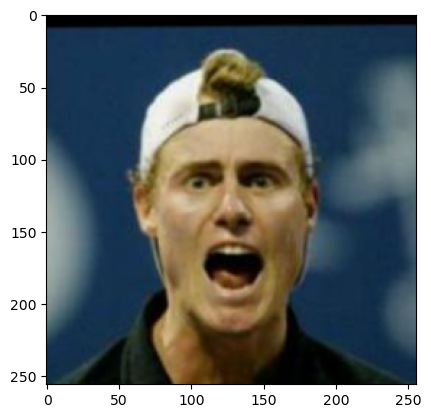

In [10]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [11]:
for x, y in dataloader:
    sample_image = x[0]
    print("Sample Image Dimensions:", sample_image.shape)
    break

Sample Image Dimensions: torch.Size([3, 256, 256])


The **first** dimension (3) represents the number of channels in the image. In this case, it is 3, indicating that the images are in RGB (Red, Green, Blue) color format.

The **second** dimension (250) represents the height of the image.

The **third** dimension (250) represents the width of the image.




# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [38]:
class AE(nn.Module):

    def __init__(self):
        super(AE,self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [39]:
# Instantiate the autoencoder
autoencoder = AE()

sample_image, _ = next(iter(dataloader))
encoded_output = autoencoder.encoder(sample_image)
decoded_output = autoencoder.decoder(encoded_output)

print("Shape of Encoder Output:", encoded_output.shape)
print("Shape of Decoder Output:", decoded_output.shape)

Shape of Encoder Output: torch.Size([32, 256, 32, 32])
Shape of Decoder Output: torch.Size([32, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [14]:
total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print("Total Number of Parameters in the Model:", total_params)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)


Total Number of Parameters in the Model: 742659


The loss function that I would choose is the Mean Squared Error. We need the input and real output to be as little as possible for autoencoders, which is why I chose MSE. The average squared distance between matching input and output items is measured by the Mean Squared Error (MSE).

Additionally, since the Adam optimizer provides quick convergence during training, that is the optimizer I would use.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
num_epochs = 10  # Or however many epochs you wish to run

for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        imgs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(imgs)
        loss = loss_function(outputs, imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}')


Epoch 1, Loss: 0.0038382258351413075
Epoch 2, Loss: 0.0011229697993258014
Epoch 3, Loss: 0.000920889395160335
Epoch 4, Loss: 0.0008463566047381295
Epoch 5, Loss: 0.0007033860645535883
Epoch 6, Loss: 0.000645477964094579
Epoch 7, Loss: 0.0005209037034709349
Epoch 8, Loss: 0.0005641524134578345
Epoch 9, Loss: 0.0004936829074001916
Epoch 10, Loss: 0.0004756690169867929


Troubleshooting to be done when the loss did not decrease:

The loss was becoming stuck at the same rate of 0.09 for the earlier models I tried.

I tried changing the learning rate from 0.01 to 0.001 in an attempt to fix it.

To help my model learn more effectively, I also added extra layers and complexity to it. I added a second layer of Maxpooling and Convolution to make it more intricate. Following that, I also changed the encoder and decoder's dimensions so that the output of the latter matched the input size of 3,250,250.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Original Image Size: torch.Size([32, 3, 256, 256])


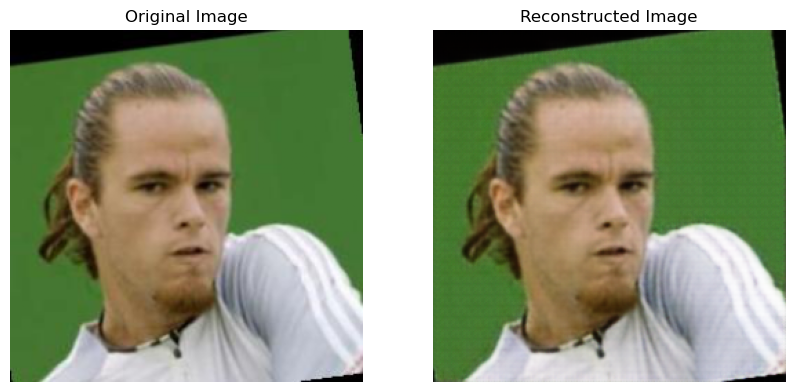

In [37]:
# Set the model to evaluation mode
autoencoder.eval()

# Choose a random image from the dataset
sample_image, _ = next(iter(dataloader))

# Print the size of the original image
print("Original Image Size:", sample_image.size())

# Ensure the tensor is dense before using permute
sample_image_dense = sample_image.to_dense() if sample_image.layout == torch.strided else sample_image.coalesce().to_dense()

# Forward pass through the autoencoder
with torch.no_grad():
    reconstructed_image = autoencoder(sample_image_dense)

# Convert the tensors to numpy arrays
sample_image_np = sample_image_dense[0].permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image[0].permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(sample_image_np, cmap='gray' if sample_image_np.ndim == 2 else None)
plt.title("Original Image")
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np, cmap='gray' if reconstructed_image_np.ndim == 2 else None)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

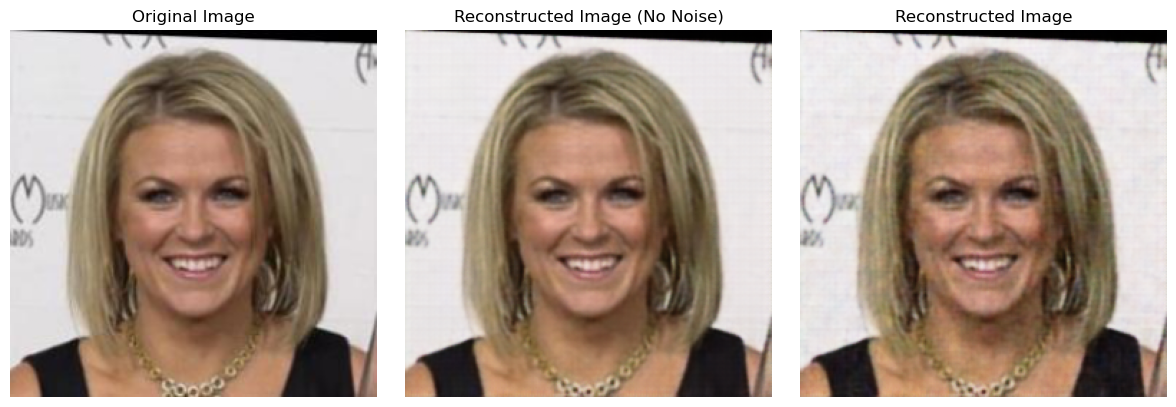

In [35]:
import random
# Select a random image from the dataset
random_index = random.randint(0, len(sample_image) - 1)
input_image= sample_image[random_index]

# Pass the input image through the model to get the latent representation
with torch.no_grad():
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image = input_image  # Move to the appropriate device
    latent_representation = autoencoder.encoder(input_image)

# Add small normally distributed noise to the latent representation
noise = torch.randn_like(latent_representation) * 0.3  # Adjusting the noise scale as needed
noisy_representation = latent_representation + noise

# Decode the noisy latent representation
with torch.no_grad():
    noisy_reconstructed_image = autoencoder.decoder(noisy_representation)

# Convert tensors to NumPy arrays for visualization, making sure to detach them
input_image_np = input_image.squeeze(0).cpu().detach().numpy()
reconstructed_image = autoencoder.decoder(latent_representation)  # Decoding the original latent representation
reconstructed_image_np = reconstructed_image.squeeze(0).cpu().detach().numpy()
noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze(0).cpu().detach().numpy()

# Ensure pixel values are within the valid range [0, 1]
input_image_np = input_image_np.clip(0, 1)
reconstructed_image_np = reconstructed_image_np.clip(0, 1)
noisy_reconstructed_image_np = noisy_reconstructed_image_np.clip(0, 1)

# Plot the original, reconstructed, and noisy reconstructed images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(input_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image (No Noise)")
plt.imshow(reconstructed_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(noisy_reconstructed_image_np.transpose(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()

The reconstructed image is significantly more deformed as a result of the input image's noise addition.

Not all of the noise in the image has been eliminated by the autoencoder.

This is because I did not introduce any noise to the input dataset during training. The reconstructed image from the noisy image would have been clearer and noise-free if the model had been trained on any noisy data.

But since this is untrue, the model has not learned how to take into account noisy data, and as a result, the rebuilt image is producing a noisy output for me.